<a href="https://colab.research.google.com/github/BarkinTopcu/company_forecasting/blob/main/Daily_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Python Sales Forecasting with AI Based - Daily Forecasting
This code documentation and code is written by Recep Barkın Topcu.

The dataset is taken from kaggle: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

This code just focus on the company transaction without store based. All sales of the all stores at each day are gathered together.

In [1]:
pip install modin[ray] -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.7 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#modin pandas is faster than pandas
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [4]:
#Dask is used for reading the csv. When I was using pandas in the other projects sometimes pandas cannot read all of the data. For that reason I prefer to use dask.
sales_df = dd.read_csv("transactions.csv")
sales_df = sales_df.compute()
sales_df

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


# Data Preprocessing

In [5]:
sales_df.drop(index=0,inplace=True) #There is only one sales info at 2013-01-01. I am deleting this data because of that.
sales_df["date"] = pd.to_datetime(sales_df["date"]) #Converting date column to datetime format

In [6]:
#Gathering all transactions of the all stores for each day.
sales_df = sales_df.groupby("date",as_index=False).agg({"transactions":"sum"})
sales_df

,date,transactions
0,2013-01-02,93215
1,2013-01-03,78504
2,2013-01-04,78494
3,2013-01-05,93573
4,2013-01-06,90464
...,...,...
1676,2017-08-11,89551
1677,2017-08-12,89927
1678,2017-08-13,85993
1679,2017-08-14,85448


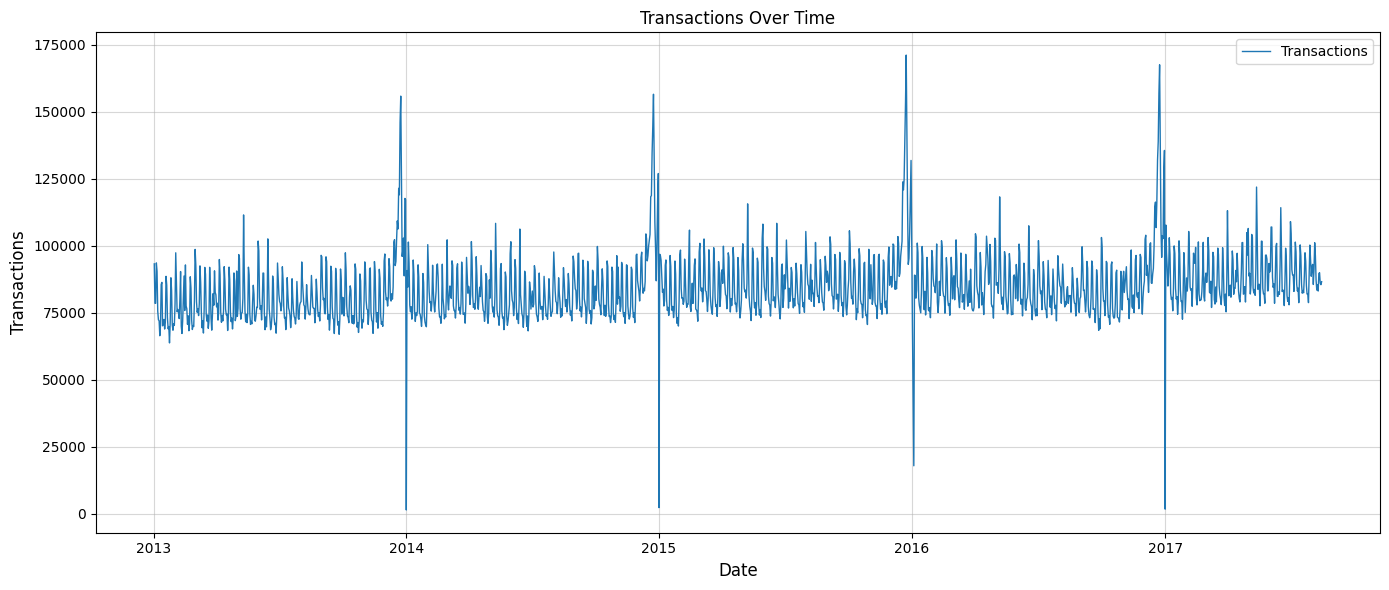

In [7]:
#Ploting the dataframe
plt.figure(figsize=(14,6))
plt.plot(sales_df["date"],sales_df["transactions"],label="Transactions",linewidth=1)
plt.title("Transactions Over Time", fontsize=12)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Transactions",fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# Forecasting with Different Methods

## Basic Type Methods

### Moving Average
This is a basic method for forecasting.

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
sales_moving = sales_df.copy()
#Creating two different moving average with 30 days and 7 days
sales_moving['moving_average_30'] = sales_moving['transactions'].rolling(window=30).mean()
sales_moving['moving_average_7'] = sales_moving['transactions'].rolling(window=7).mean()

In [9]:
#The first 29 day have NaN values because of the rolling.
y_pred = sales_moving['moving_average_30'].dropna()
y_true = sales_moving['transactions'][len(sales_moving) - len(y_pred):]

In [10]:
#Using 3 different metrics to evaluate method.
r2_mov = r2_score(y_true, y_pred)
rmse_mov = np.sqrt(mean_squared_error(y_true, y_pred))
mape_mov = mean_absolute_percentage_error(y_true, y_pred)
print(f"R^2 is {r2_mov} \n RMSE is {rmse_mov} \n MAPE is {mape_mov}")

R^2 is 0.13794754841146717 
 RMSE is 11245.957606265532 
 MAPE is 0.19658746855881928


In [11]:
#Creating a new dataframe to compare the methods in the end.
result_data = {"Method":["Moving Average - 30"],
               "R^2":[r2_mov],
               "RMSE":[rmse_mov],
               "MAPE":[mape_mov]}
results_df = pd.DataFrame(data=result_data)
results_df

2025-01-27 18:24:55,288	INFO worker.py:1841 -- Started a local Ray instance.


,Method,R^2,RMSE,MAPE
0,Moving Average - 30,0.137948,11245.957606,0.196587


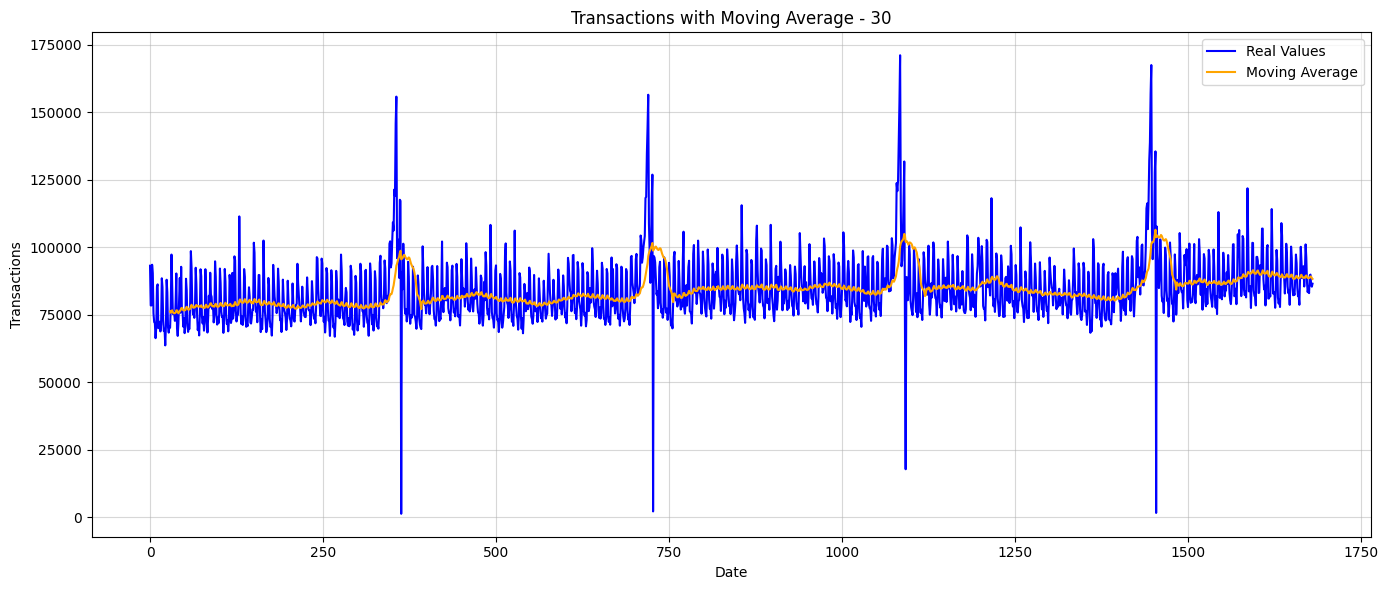

In [12]:
#Ploting the real data
plt.figure(figsize=(14, 6))
plt.plot(sales_moving.index, sales_moving['transactions'], label='Real Values', color='blue')
plt.plot(sales_moving.index, sales_moving['moving_average_30'], label='Moving Average', color='orange')
plt.title('Transactions with Moving Average - 30')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [13]:
#Similar thing with 7 days
y_pred = sales_moving['moving_average_7'].dropna()
y_true = sales_moving['transactions'][len(sales_moving) - len(y_pred):]
#Using 3 different metrics to evaluate method.
r2_mov = r2_score(y_true, y_pred)
rmse_mov = np.sqrt(mean_squared_error(y_true, y_pred))
mape_mov = mean_absolute_percentage_error(y_true, y_pred)
print(f"R^2 is {r2_mov} \n RMSE is {rmse_mov} \n MAPE is {mape_mov}")
result_data = {"Method":["Moving Average - 7"],
               "R^2":[r2_mov],
               "RMSE":[rmse_mov],
               "MAPE":[mape_mov]}
results_df = pd.concat([results_df, pd.DataFrame(result_data)], ignore_index=True)
results_df

R^2 is 0.33711855991085937 
 RMSE is 9864.605200518448 
 MAPE is 0.18279177922105586


,Method,R^2,RMSE,MAPE
0,Moving Average - 30,0.137948,11245.957606,0.196587
1,Moving Average - 7,0.337119,9864.605201,0.182792


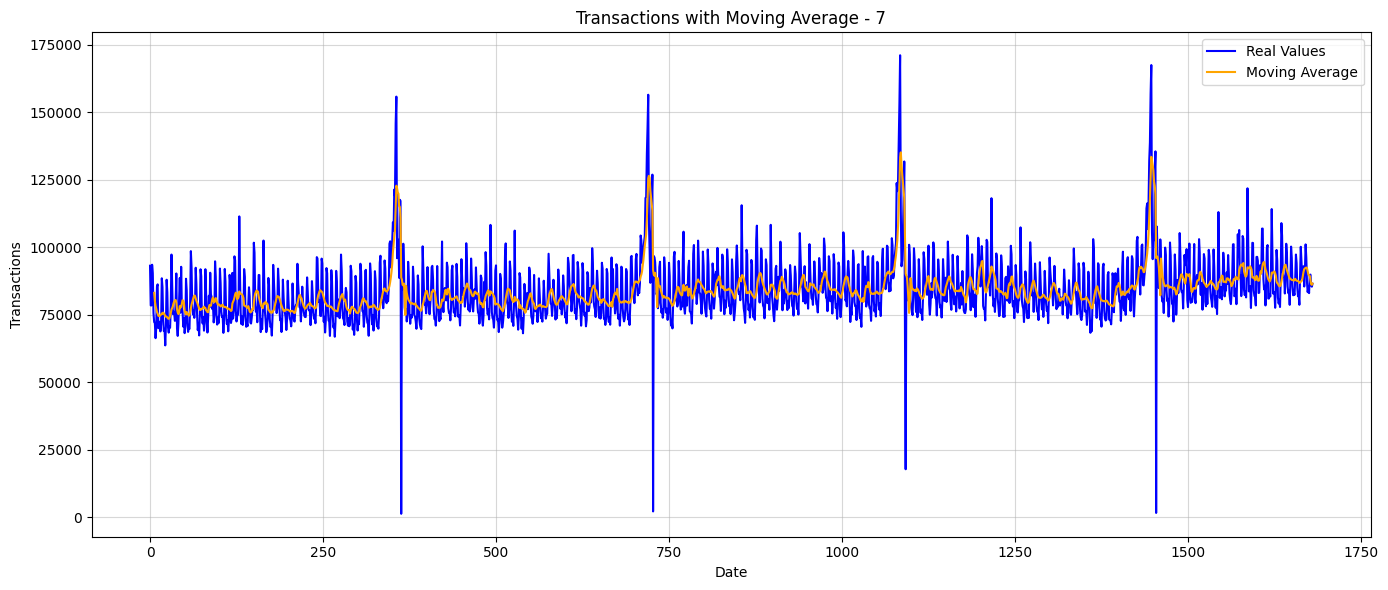

In [14]:
#Ploting the real data vs predicted
plt.figure(figsize=(14, 6))
plt.plot(sales_moving.index, sales_moving['transactions'], label='Real Values', color='blue')
plt.plot(sales_moving.index, sales_moving['moving_average_7'], label='Moving Average', color='orange')
plt.title('Transactions with Moving Average - 7')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


### Exponential Smoothing

In [15]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [16]:
model_exp = SimpleExpSmoothing(sales_df["transactions"])
fitexp_2 = model_exp.fit(smoothing_level=0.2, optimized=False)
sales_moving["exp_2"] = fitexp_2.fittedvalues #I did not want to change first dataset
fitexp_5 = model_exp.fit(smoothing_level=0.5, optimized=False)
sales_moving["exp_5"] = fitexp_5.fittedvalues

In [17]:
r2_exp_2 = r2_score(sales_moving["transactions"], sales_moving["exp_2"])
rmse_exp_2 = np.sqrt(mean_squared_error(sales_moving["transactions"], sales_moving["exp_2"]))
mape_exp_2 = mean_absolute_percentage_error(sales_moving["transactions"], sales_moving["exp_2"])
result_data = {"Method":["Exponential - 0.2"],
               "R^2":[r2_exp_2],
               "RMSE":[rmse_exp_2],
               "MAPE":[mape_exp_2]}
results_df = pd.concat([results_df, pd.DataFrame(result_data)], ignore_index=True)

r2_exp_5 = r2_score(sales_moving["transactions"], sales_moving["exp_5"])
rmse_exp_5 = np.sqrt(mean_squared_error(sales_moving["transactions"], sales_moving["exp_5"]))
mape_exp_5 = mean_absolute_percentage_error(sales_moving["transactions"], sales_moving["exp_5"])
result_data = {"Method":["Exponential - 0.5"],
               "R^2":[r2_exp_5],
               "RMSE":[rmse_exp_5],
               "MAPE":[mape_exp_5]}
results_df = pd.concat([results_df, pd.DataFrame(result_data)], ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,Moving Average - 30,0.137948,11245.957606,0.196587
1,Moving Average - 7,0.337119,9864.605201,0.182792
2,Exponential - 0.2,0.157660,11108.001862,0.215302
3,Exponential - 0.5,0.119328,11357.930512,0.218765


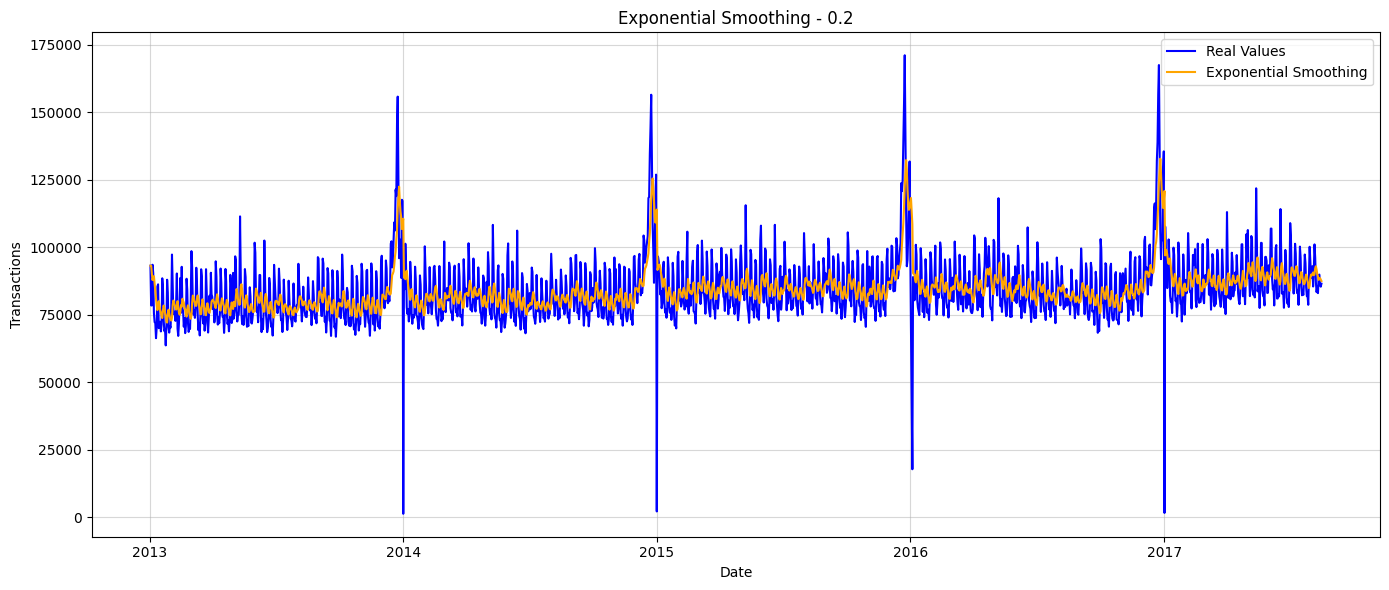

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(sales_df["date"], sales_df["transactions"], label="Real Values", color="blue")
plt.plot(sales_df["date"], sales_moving["exp_2"], label="Exponential Smoothing", color="orange")
plt.title("Exponential Smoothing - 0.2")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

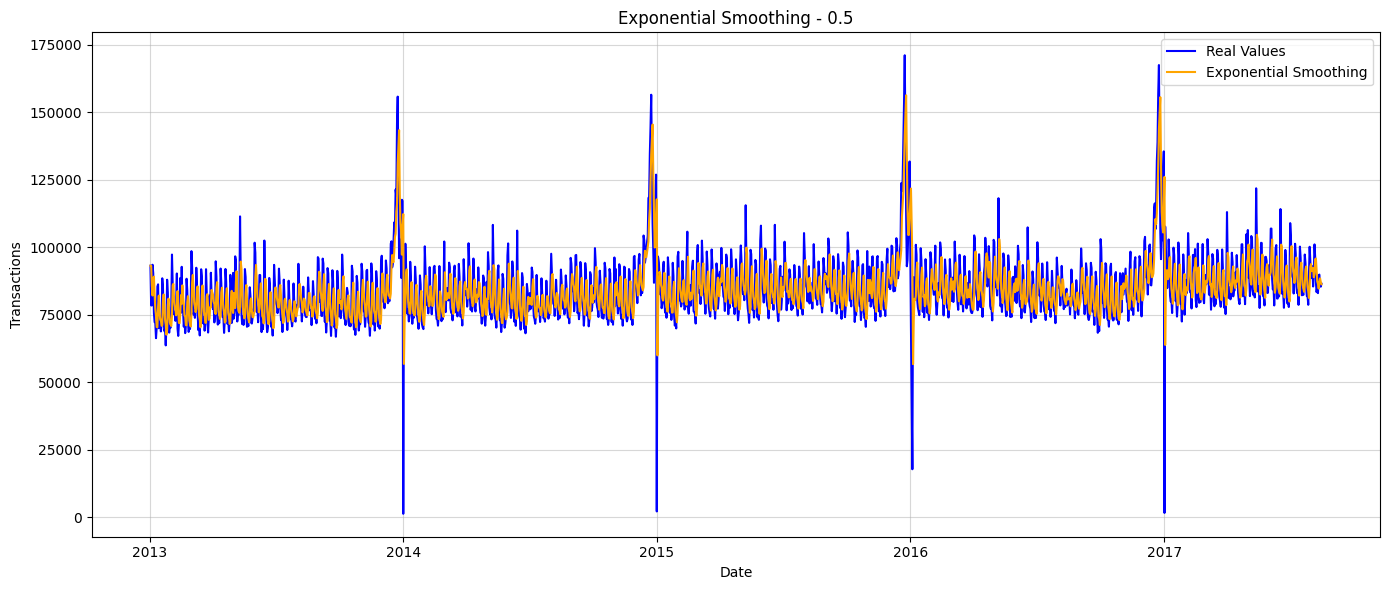

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(sales_df["date"], sales_df["transactions"], label="Real Values", color="blue")
plt.plot(sales_df["date"], sales_moving["exp_5"], label="Exponential Smoothing", color="orange")
plt.title("Exponential Smoothing - 0.5")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

## Machine Learning

In [20]:
#I added some columns for deep learning and machine learning techniques.
#Firstly, national holidays are added.
holidays_df = dd.read_csv("holidays_events.csv")
holidays_df = holidays_df.compute()
holidays_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [21]:
holidays_df.drop(columns=["type","locale_name","description","transferred"],inplace=True)
holidays_df = holidays_df[holidays_df['locale'] == 'National']
sales_df['is_holiday'] = sales_df['date'].isin(holidays_df['date']).astype(int)
sales_df

,date,transactions,is_holiday
0,2013-01-02,93215,0
1,2013-01-03,78504,0
2,2013-01-04,78494,0
3,2013-01-05,93573,1
4,2013-01-06,90464,0
...,...,...,...
1676,2017-08-11,89551,1
1677,2017-08-12,89927,0
1678,2017-08-13,85993,0
1679,2017-08-14,85448,0


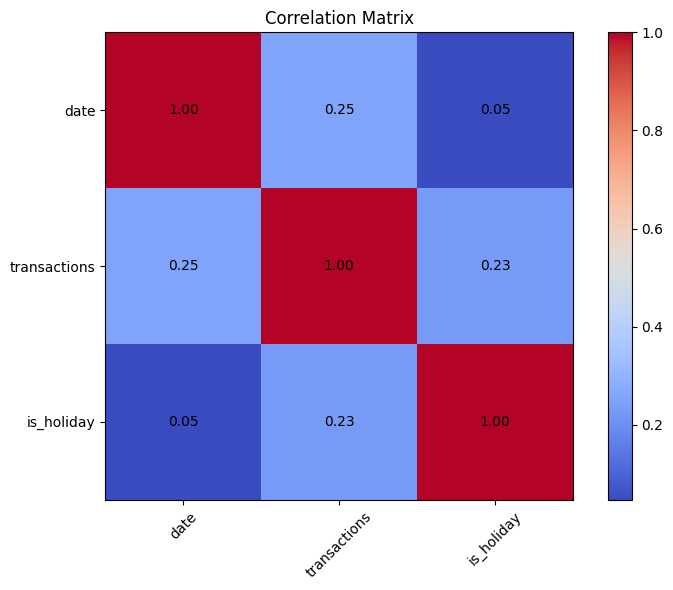

In [22]:
correlation_matrix = sales_df.corr()
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Correlation Matrix")
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        value = correlation_matrix.iloc[i, j]
        plt.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

In [42]:
#Here, I added a column to the table that contains the average up to a specific day in the past
for window in [3, 7, 30]:
    sales_df[f'past_rolling_mean_{window}'] = sales_df['transactions'].rolling(window).mean().shift(1)

#Creating lags
for lag in range(1, 61):
    sales_df[f'lag_{lag}'] = sales_df['transactions'].shift(lag)

#Seperating date to year, month and day
sales_df['year'] = sales_df['date'].dt.year
sales_df['month'] = sales_df['date'].dt.month
sales_df['day'] = sales_df['date'].dt.day

In [43]:
sales_df

,date,transactions,is_holiday,past_rolling_mean_3,past_rolling_mean_7,past_rolling_mean_30,lag_1,lag_2,lag_3,lag_4,...,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,year,month,day
0,2013-01-02,93215,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,1,2
1,2013-01-03,78504,0,NaN,NaN,NaN,93215.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,1,3
2,2013-01-04,78494,0,NaN,NaN,NaN,78504.0,93215.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,1,4
3,2013-01-05,93573,1,83404.333333,NaN,NaN,78494.0,78504.0,93215.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,1,5
4,2013-01-06,90464,0,83523.666667,NaN,NaN,93573.0,78494.0,78504.0,93215.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,2017-08-11,89551,1,83979.333333,89655.000000,88652.166667,83064.0,85452.0,83422.0,87072.0,...,99193.0,114201.0,92852.0,81831.0,82752.0,81063.0,81080.0,2017,8,11
1677,2017-08-12,89927,0,86022.333333,89404.428571,88832.033333,89551.0,83064.0,85452.0,83422.0,...,82891.0,99193.0,114201.0,92852.0,81831.0,82752.0,81063.0,2017,8,12
1678,2017-08-13,85993,0,87514.000000,87807.142857,89205.600000,89927.0,89551.0,83064.0,85452.0,...,83508.0,82891.0,99193.0,114201.0,92852.0,81831.0,82752.0,2017,8,13
1679,2017-08-14,85448,0,88490.333333,86354.428571,89149.666667,85993.0,89927.0,89551.0,83064.0,...,82929.0,83508.0,82891.0,99193.0,114201.0,92852.0,81831.0,2017,8,14


### Decision Tree

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [45]:
X = sales_df.drop(columns=["date", "transactions"])
y = sales_df["transactions"]

In [48]:
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [49]:
dt = DecisionTreeRegressor(random_state=42)

In [51]:
#Creating some parameters to find the best model for prediction
param_grid = {
    "max_depth": [5, 10],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 5],
    "max_features": ["log2", None],
}

In [52]:
#Grid Search
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5}


In [53]:
y_pred_decision = best_model.predict(X_test)

In [74]:
r2_dec= r2_score(y_test, y_pred_decision)
rmse_dec = np.sqrt(mean_squared_error(y_test, y_pred_decision))
mape_dec = mean_absolute_percentage_error(y_test, y_pred_decision)
result_data = {"Method":["Decision Tree"],
               "R^2":[r2_dec],
               "RMSE":[rmse_dec],
               "MAPE":[mape_dec]}
results_df = pd.concat([results_df, pd.DataFrame(result_data)], ignore_index=True)

In [67]:
X_date = pd.DataFrame()
X_date["date"] = pd.to_datetime(X_test[["year", "month", "day"]])

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


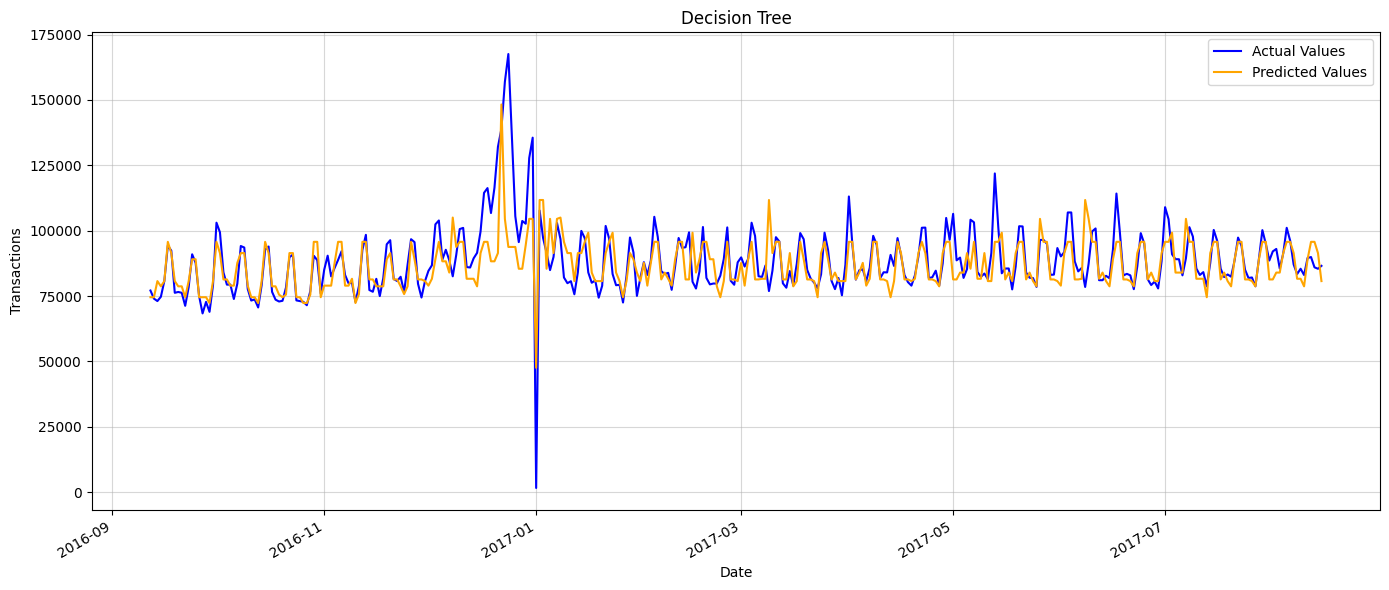

In [70]:
plt.figure(figsize=(14, 6))
plt.plot(X_date["date"],y_test.values, label="Actual Values", color="blue")
plt.plot(X_date["date"],y_pred_decision, label="Predicted Values", color="orange")
plt.title("Decision Tree")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### Linear Regression

In [71]:
from sklearn.linear_model import LinearRegression

In [73]:
lr = LinearRegression()
X_train_no_NaN = X_train.fillna(0)
X_test_no_NaN = X_test.fillna(0)
lr.fit(X_train_no_NaN, y_train)
y_pred_linear = lr.predict(X_test_no_NaN)

In [75]:
r2_linear= r2_score(y_test, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
mape_linear = mean_absolute_percentage_error(y_test, y_pred_linear)
result_data = {"Method":["Linear Regression"],
               "R^2":[r2_linear],
               "RMSE":[rmse_linear],
               "MAPE":[mape_linear]}
results_df = pd.concat([results_df, pd.DataFrame(result_data)], ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,Moving Average - 30,0.137948,11245.957606,0.196587
1,Moving Average - 7,0.337119,9864.605201,0.182792
2,Exponential - 0.2,0.157660,11108.001862,0.215302
3,Exponential - 0.5,0.119328,11357.930512,0.218765
4,Decision Tree,0.446136,9687.815457,0.142646
5,Linear Regression,0.466726,9506.037457,0.249019


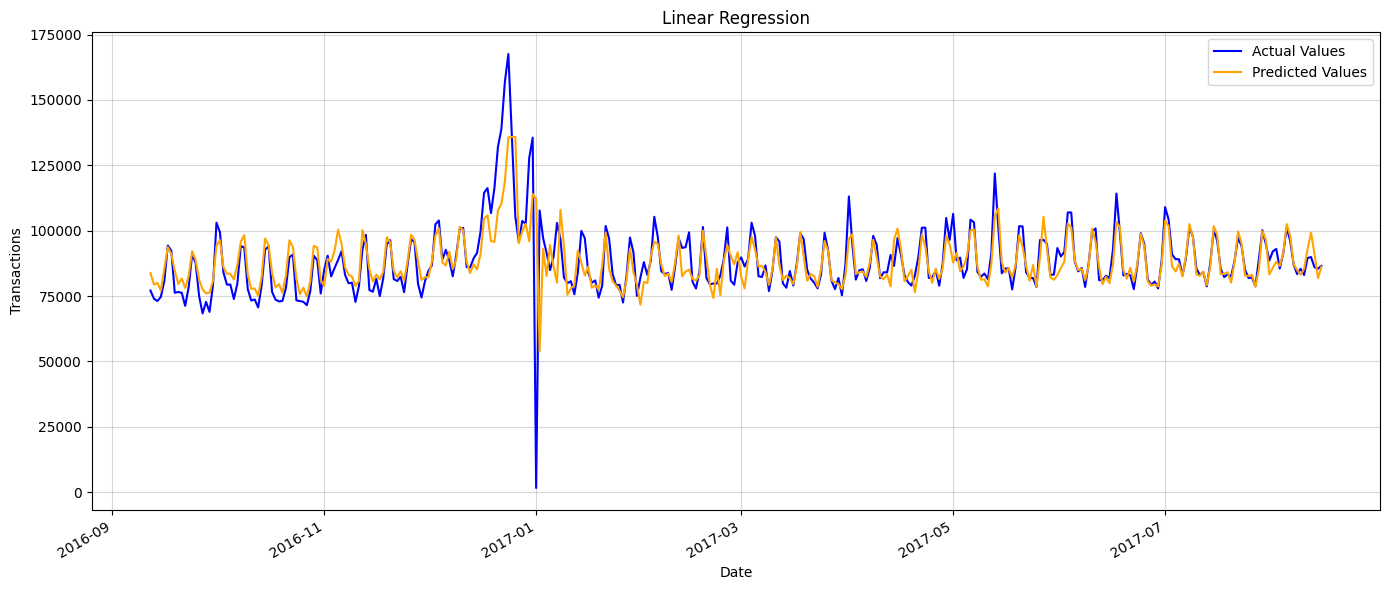

In [76]:
plt.figure(figsize=(14, 6))
plt.plot(X_date["date"],y_test.values, label="Actual Values", color="blue")
plt.plot(X_date["date"],y_pred_linear, label="Predicted Values", color="orange")
plt.title("Linear Regression")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### Random Forest

In [77]:
from sklearn.ensemble import RandomForestRegressor

In [78]:
rf = RandomForestRegressor(random_state=42)
param_grid = {
    "n_estimators": [100],
    "max_depth": [None, 10, 30],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True, False],         # Whether bootstrap samples are used when building trees
}

In [79]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 30],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5], 'n_estimators': [100]},
             scoring='neg_mean_absolute_error', verbose=2)

In [80]:
best_model = grid_search.best_estimator_

In [81]:
y_pred_random = best_model.predict(X_test)

In [82]:
r2_random= r2_score(y_test, y_pred_random)
rmse_random = np.sqrt(mean_squared_error(y_test, y_pred_random))
mape_random = mean_absolute_percentage_error(y_test, y_pred_random)
result_data = {"Method":["Random Forest"],
               "R^2":[r2_random],
               "RMSE":[rmse_random],
               "MAPE":[mape_random]}
results_df = pd.concat([results_df, pd.DataFrame(result_data)], ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,Moving Average - 30,0.137948,11245.957606,0.196587
1,Moving Average - 7,0.337119,9864.605201,0.182792
2,Exponential - 0.2,0.157660,11108.001862,0.215302
3,Exponential - 0.5,0.119328,11357.930512,0.218765
4,Decision Tree,0.446136,9687.815457,0.142646
5,Linear Regression,0.466726,9506.037457,0.249019
6,Random Forest,0.670797,7468.897623,0.152827


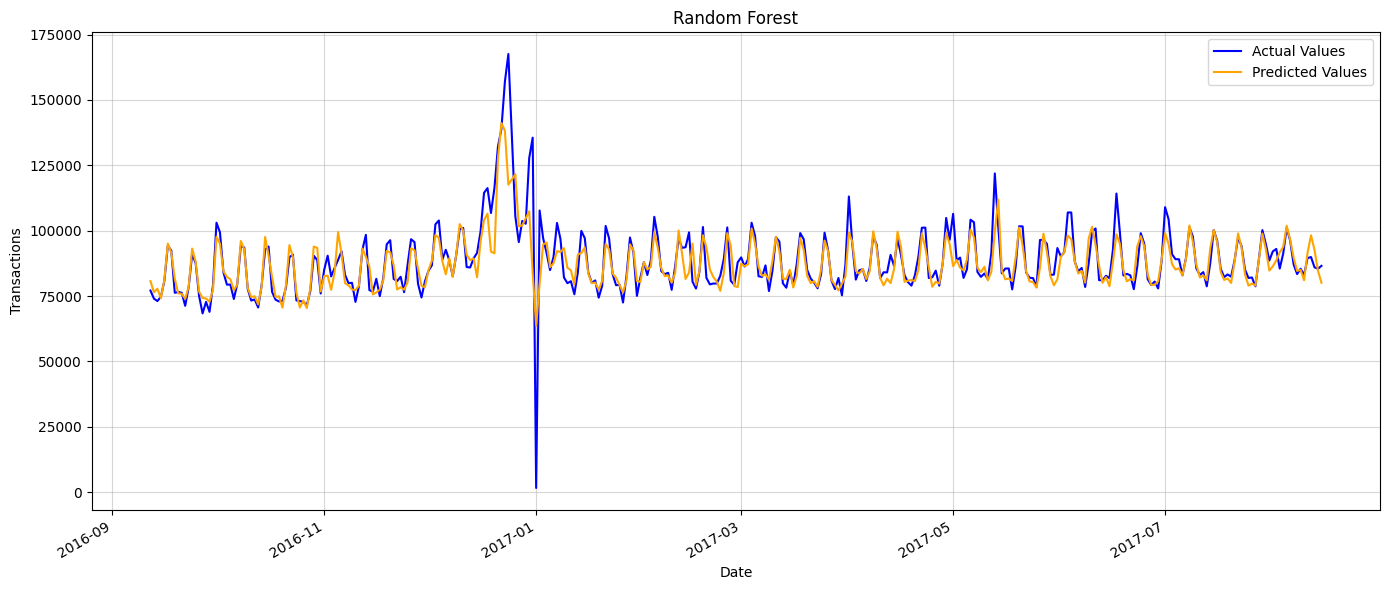

In [83]:
plt.figure(figsize=(14, 6))
plt.plot(X_date["date"],y_test.values, label="Actual Values", color="blue")
plt.plot(X_date["date"],y_pred_random, label="Predicted Values", color="orange")
plt.title("Random Forest")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### Support Vector Regression

In [84]:
from sklearn.svm import SVR

In [85]:
svr = SVR()
param_grid = {
    "kernel": ["linear", "poly"],
    "C": [0.1, 1, 10],
    "gamma": ["auto", 0.1, 0.01]
}


#

In [ ]:
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

In [ ]:
y_pred_SVR = best_model.predict(X_test)
r2_SVR= r2_score(y_test, y_pred_SVR)
rmse_SVR = np.sqrt(mean_squared_error(y_test, y_pred_SVR))
mape_SVR = mean_absolute_percentage_error(y_test, y_pred_SVR)
result_data = {"Method":["SVR"],
               "R^2":[r2_SVR],
               "RMSE":[rmse_SVR],
               "MAPE":[mape_SVR]}
results_df = pd.concat([results_df, pd.DataFrame(result_data)], ignore_index=True)
results_df

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(X_date["date"],y_test.values, label="Actual Values", color="blue")
plt.plot(X_date["date"],y_pred_SVR, label="Predicted Values", color="orange")
plt.title("SVR")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    "n_estimators": [100],
    "max_depth": [3, 7],
    "learning_rate": [0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

In [ ]:
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

In [ ]:
y_pred_XGBoost = best_model.predict(X_test)
r2_XGBoost= r2_score(y_test, y_pred_XGBoost)
rmse_XGBoost = np.sqrt(mean_squared_error(y_test, y_pred_XGBoost))
mape_XGBoost = mean_absolute_percentage_error(y_test, y_pred_XGBoost)
result_data = {"Method":["SVR"],
               "R^2":[r2_XGBoost],
               "RMSE":[rmse_XGBoost],
               "MAPE":[mape_XGBoost]}
results_df = pd.concat([results_df, pd.DataFrame(result_data)], ignore_index=True)
results_df